In [44]:
import pandas as pd,numpy as np, seaborn as sns,re,random,matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import xgboost as xgb

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/fmathews11/Loan_Text/main/loans.csv',low_memory=False)
df.sample(5)

,ID,LOAN_AMNT,TERM,INSTALLMENT,GRADE,SUB_GRADE,EMP_LENGTH,HOME_OWNERSHIP,ANNUAL_INC,VERIFICATION_STATUS,ISSUE_D,PYMNT_PLAN,desc,PURPOSE,ADDR_STATE,DTI,DELINQ_2YRS,INQ_LAST_6MTHS,OPEN_ACC,PUB_REC,REVOL_BAL,REVOL_UTIL,TOTAL_ACC,BAD_LOAN,CREDIT_LENGTH
34256,374666,7200,36 months,231.08,A,A5,1,MORTGAGE,51150,not verified,1230768000000,n,I just purchased a new vehicle and would like ...,debt_consolidation,CA,12.53,0,2,8,0,1596,8.9,11,0,7
9872,817326,3600,36 months,124.43,C,C4,3,MORTGAGE,76000,not verified,1309478400000,n,NaN,debt_consolidation,MA,10.97,0,1,14,1,9565,85.4,28,0,13
9469,767458,17000,60 months,452.77,F,F1,10,MORTGAGE,100650,verified,1309478400000,n,NaN,debt_consolidation,NC,10.27,0,0,6,0,20863,75.5,19,1,13
23230,569876,14400,60 months,311.3,B,B2,6,MORTGAGE,56000,verified,1280620800000,n,NaN,debt_consolidation,NY,4.54,0,2,10,0,1553,1.6,23,0,18
36896,515581,15000,36 months,522.41,D,D3,3,MORTGAGE,120000,verified,1272672000000,n,Borrower added on 05/13/10 > With 3 years in...,credit_card,CA,13.5,1,0,7,0,115310,86.6,22,0,25


In [ ]:
df.describe()

,BAD_LOAN
count,38980.000000
mean,0.159159
std,0.365829
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
df2 = df[df.desc.notnull()][['desc','BAD_LOAN']]
df2

,desc,BAD_LOAN
0,Borrower added on 12/22/11 > I need to upgra...,0
1,Borrower added on 12/22/11 > I plan to use t...,1
3,Borrower added on 12/21/11 > to pay for prop...,0
5,Borrower added on 12/16/11 > Downpayment for...,0
6,Borrower added on 12/21/11 > I own a small h...,1
...,...,...
38975,I am getting married on July 28 and will need ...,0
38976,I would like to buy some new furniture in my a...,0
38977,"I need to pay $2,100 for fixing my Volvo :) A...",0
38978,"Hi, I'm buying a used car. Anybody on faceb...",0


In [6]:
stop_words = set(stopwords.words('english'))

def clean_descriptions(text_string):
  text_string = text_string.upper()
  text_string = text_string.replace("<BR/>","")
  text_string = text_string.replace("<BR>","")
  text_string = text_string.replace("BORROWER ADDED ON","")
  text_sring =  text_string.replace("ADDED ON","")
  text_string = text_string.replace(">","")
  text_string = text_string.strip()
  chars_to_remove = [")","(",".","|","[","]","{","}","'","-",","]
  rx = '[' + re.escape(''.join(chars_to_remove)) + ']' 
  text_string = re.sub(rx, '', text_string)
  text_string = text_string.split()
  for idx,i in enumerate(text_string):
    if len(i) >= 6:
      if i[2] == "/" and i[5]== "/":
        text_string.pop(idx)
  text_string = ' '.join(text_string)
  tokenized = word_tokenize(text_string)
  final = []
  [final.append(i) for i in tokenized if i.isalpha() and i.lower() not in stop_words]
  text_string = " ".join(final)
  return text_string

In [7]:
df2['desc_clean'] = df2['desc'].map(clean_descriptions)
df2.sample(10)

,desc,BAD_LOAN,desc_clean
12866,Borrower added on 05/19/11 > I am a lender. ...,0,LENDER WOULD LIKE SEE BORROWER FEELS BORROWING
4895,Borrower added on 10/08/11 > My monthly expe...,0,MONTHLY EXPENSES INCLUDING RENT UTILITIES ECT
34809,Before my full time employment and while in co...,0,FULL TIME EMPLOYMENT COLLEGE ACCUMULATED AROUN...
11295,Borrower added on 06/18/11 > This loan is a ...,0,LOAN BACK CASH FLOW PIZZERIA FRANCHISE PURCHAS...
32507,I will be using this loan amount to complete ...,1,USING LOAN AMOUNT COMPLETE ARCHITECTURAL PROJE...
20093,Borrower added on 11/26/10 > Proceeds to be ...,1,PROCEEDS USED ELIMINATE HIGHER RATE CARD BALAN...
35364,I would like to do some general home improveme...,1,WOULD LIKE GENERAL HOME IMPROVEMENT ENERGY EFF...
28119,Borrower added on 03/11/10 > I am a Lending ...,0,LENDING CLUB PROSPER LENDER INVESTED HIGHER IN...
17990,Borrower added on 01/18/11 > I'm using a gre...,0,IM USING GREAT RATE LENDING CLUB CONSOLIDATE D...
25452,Borrower added on 06/27/10 > If you all keep...,1,KEEP FUNDING GOS FINE LOAN PAID APRIL THANK EV...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


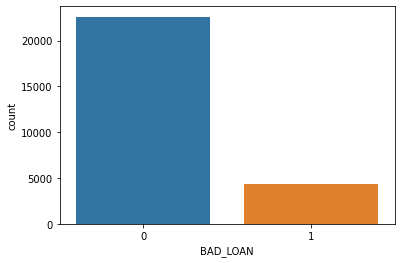

In [10]:
sns.countplot(df2.BAD_LOAN);

In [11]:
pd.Series(' '.join(df2[df2.BAD_LOAN == 1]['desc_clean']).split()).value_counts().to_frame("word_count").head(25)

,word_count
LOAN,3916
CREDIT,3550
PAY,2908
DEBT,1983
YEARS,1620
CARDS,1438
TIME,1401
WOULD,1365
PAYMENT,1337
CARD,1255


In [ ]:
pd.Series(' '.join(df2[df2.BAD_LOAN == 0]['desc_clean']).split()).value_counts().to_frame("word_count").head(25)

,word_count
LOAN,21903
CREDIT,21222
PAY,15576
DEBT,11970
YEARS,9041
CARD,8999
INTEREST,7942
CARDS,7695
PAYMENT,7398
WOULD,6426


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


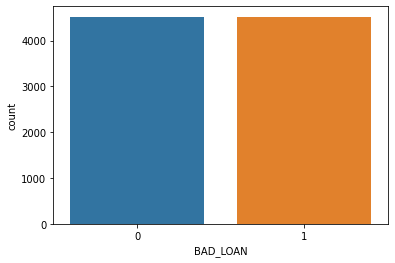

In [12]:
X = df2.desc_clean
y = df2.BAD_LOAN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42,stratify = y)
vect = TfidfVectorizer(analyzer = 'word')
X_train_transformed = vect.fit_transform(X_train)
X_test_transformed = vect.transform(X_test)
oversample = SMOTE()
X_train_transformed, y_train = oversample.fit_resample(X_train_transformed, y_train)
sns.countplot(y_train)

In [ ]:
clf = LinearSVC(C = 100,max_iter = 10000)
score = cross_val_score(clf,X_train_transformed,y_train,cv =10)
clf.fit(X_train_transformed,y_train)
print(score)
print(accuracy_score(y_test,clf.predict(X_test_transformed)))

KeyboardInterrupt: ignored

In [ ]:
eval_dict = {key:[] for key in ("trees",'train_accuracy','test_accuracy')}
for i in tqdm(range(50,2000,50)):
  clf = RandomForestClassifier(n_estimators = 500,n_jobs = -1,max_samples = 0.05)
  clf.fit(X_train_transformed,y_train)
  eval_dict['trees'].append(i)
  eval_dict['train_accuracy'].append(accuracy_score(y_train,clf.predict(X_train_transformed)))
  eval_dict['test_accuracy'].append(accuracy_score(y_test,clf.predict(X_test_transformed)))
pd.DataFrame.from_dict(eval_dict)

100%|██████████| 39/39 [04:46<00:00,  7.35s/it]


,trees,train_accuracy,test_accuracy
0,50,0.823601,0.689155
1,100,0.822716,0.686284
2,150,0.821831,0.681052
3,200,0.820947,0.687720
4,250,0.816633,0.683645
5,300,0.824818,0.689711
6,350,0.818956,0.683738
7,400,0.822274,0.682395
8,450,0.821500,0.685266
9,500,0.820283,0.684988


In [25]:
eval_dict = {key:[] for key in ("C",'train_score','test_score')}
for i in tqdm(np.linspace(0.001,0.5,50)):
  clf = LogisticRegression(n_jobs = -1,C = i)
  clf.fit(X_train_transformed,y_train)
  eval_dict['C'].append(i)
  eval_dict['train_score'].append(clf.score(X_train_transformed,y_train))
  eval_dict['test_score'].append(clf.score(X_test_transformed,y_test))
pd.DataFrame.from_dict(eval_dict)

100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


,C,train_score,test_score
0,0.001000,0.680491,0.618124
1,0.011184,0.692435,0.628774
2,0.021367,0.700066,0.636460
3,0.031551,0.706591,0.642295
4,0.041735,0.713117,0.647944
5,0.051918,0.716545,0.649935
6,0.062102,0.721964,0.652899
7,0.072286,0.725282,0.655353
8,0.082469,0.729153,0.656927
9,0.092653,0.732913,0.658316


In [43]:
pca = PCA(n_components = 2000)
X_train_pca = pca.fit_transform(X_train_transformed.todense())
np.sum(pca.explained_variance_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


0.6496009593471248

In [71]:
eval_dict = {key:[] for key in ('trees','train_score','test_score')}
for i in tqdm(range(10,100,1)):
  clf = xgb.XGBClassifier(n_jobs = -1,max_depth = 2,n_estimators=i)
  clf.fit(X_train_transformed,y_train)
  eval_dict['train_score'].append(clf.score(X_train_transformed,y_train))
  eval_dict['test_score'].append(clf.score(X_test_transformed,y_test))
  eval_dict['trees'].append(i)
pd.DataFrame.from_dict(eval_dict)

100%|██████████| 90/90 [02:44<00:00,  1.83s/it]


,trees,train_score,test_score
0,10,0.654944,0.609835
1,11,0.644769,0.800380
2,12,0.658040,0.612197
3,13,0.649746,0.802741
4,14,0.650077,0.801352
...,...,...,...
85,95,0.737447,0.711289
86,96,0.737669,0.711660
87,97,0.738222,0.712354
88,98,0.739217,0.713002


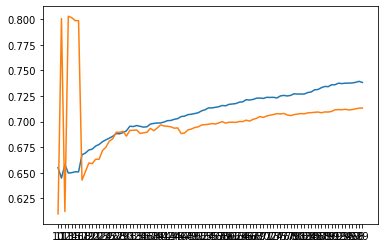

In [73]:
#plt.plot(eval_dict['depth'])
plt.plot(eval_dict['train_score'])
plt.plot(eval_dict['test_score'])
plt.xticks([idx for idx,i in enumerate(range(10,100,1))],eval_dict['trees'])
plt.show();